In [203]:
import random 
random.seed(10)

In [204]:
from nnmnkwii.datasets import PaddedFileSourceDataset
from nnmnkwii.datasets.cmu_arctic import CMUArcticWavFileDataSource
from nnmnkwii.preprocessing.alignment import DTWAligner
from nnmnkwii.util import trim_zeros_frames, remove_zeros_frames
from nnmnkwii.metrics import melcd
from nnmnkwii.baseline.gmm import MLPG
import os
from os.path import basename, splitext
import sys
import time
import matplotlib.pyplot as plt
import pyroomacoustics as pra
import numpy as np
from scipy.io import wavfile
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.model_selection import train_test_split
import soundfile as sf
import pyworld
import pysptk
from pysptk.synthesis import MLSADF, Synthesizer
import librosa
import librosa.display
import IPython
from IPython.display import Audio
# from nnmnkwii.preprocessing import DeltaAppender

In [205]:
DATA_ROOT = "C:\\Users\\YASH\\Desktop\\SAP_Project\\"

In [206]:
basedir = "C:\\Users\\YASH\\Desktop\\SAP_Project"
corpus = pra.datasets.CMUArcticCorpus(basedir=basedir, download=True, speaker=['ksp', 'jmk'])

In [207]:
ksp_list = os.listdir(DATA_ROOT + 'cmu_us_ksp_arctic/wav')
len(ksp_list)

1132

Data specification

In [208]:
fs = 16000
fftlen = pyworld.get_cheaptrick_fft_size(fs)
alpha = pysptk.util.mcepalpha(fs)
order = 24
frame_period = 5
hop_length = int(fs * (frame_period * 0.001))
max_files = 100 # number of utterances to be used.
test_size = 0.1
use_delta = True

if use_delta:
    windows = [
        (0, 0, np.array([1.0])),
        (1, 1, np.array([-0.5, 0.0, 0.5])),
        (1, 1, np.array([1.0, -2.0, 1.0])),
    ]
else:
    windows = [
        (0, 0, np.array([1.0])),
    ]

Process voice data

In [209]:
def extract_additional_features(y, sr):
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
    rms = librosa.feature.rms(y=y, hop_length=hop_length)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=hop_length)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=hop_length)
    spectral_flatness = librosa.feature.spectral_flatness(y=y, hop_length=hop_length)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=hop_length)

    # Concatenate time-domain and frequency-domain features
    features = np.concatenate((chroma_stft, rms, spectral_centroid, spectral_bandwidth,
                            spectral_contrast, spectral_flatness, spectral_rolloff,
                            zero_crossing_rate), axis=0)
    features = features.T     # transpose 
    # print("feat:", features.shape, rms.shape, spectral_contrast.shape, chroma_stft.shape, zero_crossing_rate.shape, spectral_centroid.shape, spectral_bandwidth.shape, spectral_flatness.shape, spectral_rolloff.shape)
    return features

In [210]:
class MyFileDataSource(CMUArcticWavFileDataSource):
    def __init__(self, *args, **kwargs):
        super(MyFileDataSource, self).__init__(*args, **kwargs)
        self.test_paths = None

    def collect_files(self):
        paths = super(
            MyFileDataSource, self).collect_files()
        paths_train, paths_test = train_test_split(
            paths, test_size=test_size, random_state=1234)

        # keep paths for later testing
        self.test_paths = paths_test

        return paths_train

    def collect_features(self, path):
        fs, x = wavfile.read(path)
        x = x.astype(np.float64)
        f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
        f0 = pyworld.stonemask(x, f0, timeaxis, fs)
        spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
        spectrogram = trim_zeros_frames(spectrogram)
        mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)

        # # additional features
        features = extract_additional_features(x, fs)

        # discard first frame for consistency
        if len(mc) > len(features):
            mc = mc[1:,:]
        elif len(features) > len(mc):
            features = features[1:,:]
        # print("input, mc, features:", x.shape, mc.shape, features.shape)

        # Make sure the lengths of the features are equal
        if len(mc) > len(features):
            print(f"Unequal length: MC = {mc.shape} , Feat = {features.shape}")
            features = np.pad(features, (len(mc) - len(features), 0), 'constant')
        elif len(features) > len(mc):
            print(f"Unequal length: MC = {mc.shape} , Feat = {features.shape}")
            mc = np.pad(mc, (len(features) - len(mc), 0), 'constant')
        
        mc = np.concatenate([mc, features], axis=1)
        # print("Final Feat:", mc.shape)
        return mc

In [211]:
ksp_source = MyFileDataSource(data_root=DATA_ROOT,
                                         speakers=["ksp"], max_files=max_files)
jmk_source = MyFileDataSource(data_root=DATA_ROOT,
                                         speakers=["jmk"], max_files=max_files)

X = PaddedFileSourceDataset(ksp_source, 1200).asarray()
Y = PaddedFileSourceDataset(jmk_source, 1200).asarray()
print(X.shape)
print(Y.shape)

(90, 1200, 50)
(90, 1200, 50)


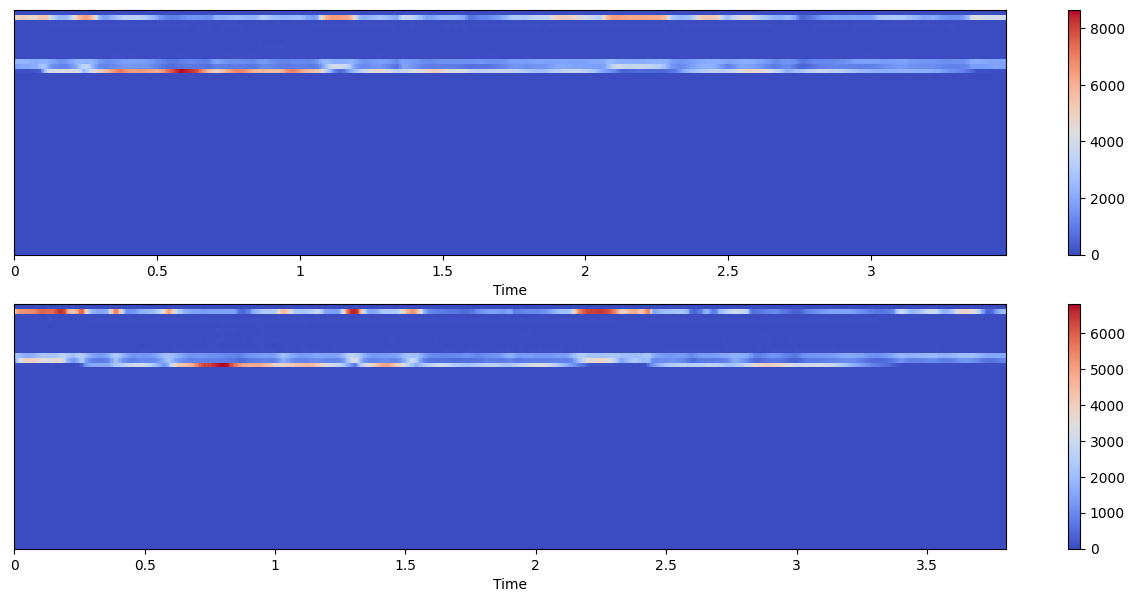

In [212]:
# Plotting util
def plot_parallel(x,y):
    plt.figure(figsize=(16,7))
    plt.subplot(2,1,1)
    librosa.display.specshow(trim_zeros_frames(x).T, sr=fs, hop_length=hop_length, x_axis="time")
    plt.colorbar()
    plt.subplot(2,1,2)
    librosa.display.specshow(trim_zeros_frames(y).T, sr=fs, hop_length=hop_length, x_axis="time")
    plt.colorbar()

# idx=7
idx = 22 # any
plot_parallel(X[idx],Y[idx])

Align source and target features: Use DTW

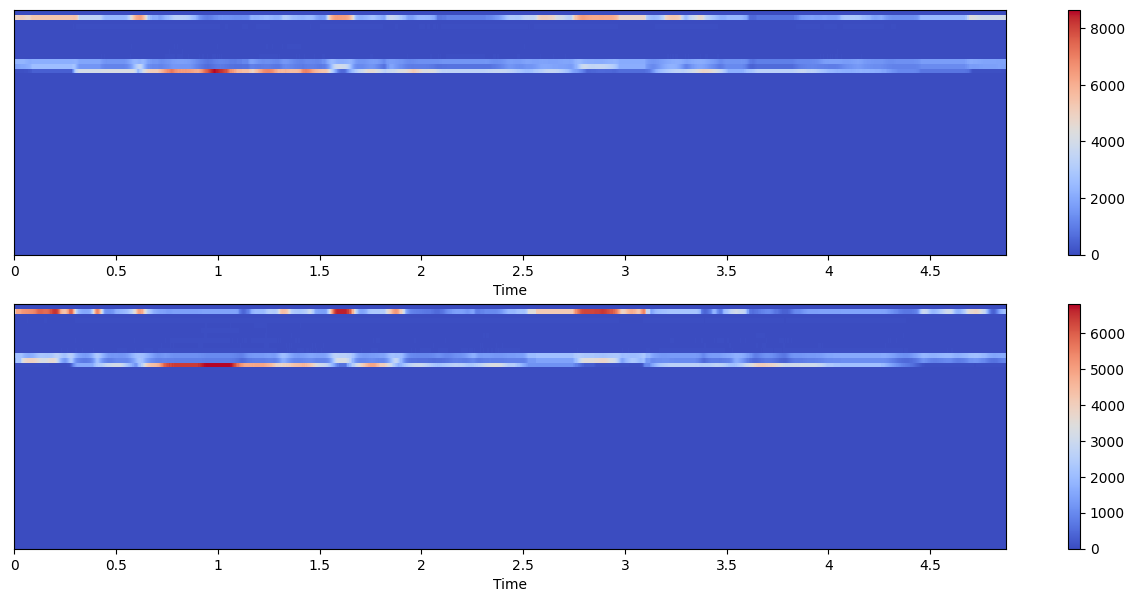

In [213]:
# Alignment
X_aligned, Y_aligned = DTWAligner(verbose=0, dist=melcd).transform((X, Y))
plot_parallel(X_aligned[idx],Y_aligned[idx])

In [214]:
# 0-th mel-cesptrum is a power coefficient by definition 
# Focus on spectral charactaristics, drop 1-st dimention from aligned features
# Drop 1st (power) dimention
X_aligned, Y_aligned = X_aligned[:, :, 1:], Y_aligned[:, :, 1:]
X_aligned.shape, Y_aligned.shape

((90, 1375, 49), (90, 1375, 49))

In [215]:
from nnmnkwii.util import trim_zeros_frames

def _delta(x, window):
    return np.correlate(x, window, mode="same")

def delta(x, window):
    """Returns delta features given a static features and a window.

    Args:
        x (numpy.ndarray): Input static features, of shape (``T x D``).
        window (numpy.ndarray): Window coefficients.

    Returns:
        (ndarray): Delta features, shape (``T x D``).

    Examples:
        >>> from nnmnkwii.util import delta
        >>> T, static_dim = 10, 24
        >>> x = np.random.rand(T, static_dim)
        >>> window = np.array([-0.5, 0.0, 0.5]) # window for delta feature
        >>> y = delta(x, window)
        >>> assert x.shape == y.shape
    """
    T, D = x.shape
    y = np.zeros_like(x)
    for d in range(D):
        y[:, d] = _delta(x[:, d], window)
    return y

class UtteranceWiseTransformer(object):
    def transform(self, X, lengths=None):
        assert X.ndim == 3
        N, T, D = X.shape
        Y = np.zeros(self.get_shape(X), dtype=X.dtype)
        for idx, x in enumerate(X):
            if lengths is None:
                x = trim_zeros_frames(x)
            else:
                x = x[:lengths[idx]]
            y = self.do_transform(x)
            Y[idx][:len(y)] = y
        return Y

    def get_shape(self, X):
        raise NotImplementedError
    
class DeltaAppender(UtteranceWiseTransformer):
    """Append delta features.

    Given a ``N x T x D`` array, features of multiple utterances,
    transform features into static + delta features for each utterance.

    Attributes:
        windows (list): A sequence of windows. See
          :func:`nnmnkwii.functions.mlpg` for what window means.
    """

    def __init__(self, windows):
        self.windows = windows

    def get_shape(self, X):
        N, T, D = X.shape
        return (N, T, D * len(self.windows))

    def do_transform(self, x):
        features = []
        for _, _, window in self.windows:
            features.append(delta(x, window))
        combined_features = np.hstack(features)
        return combined_features


Add delta features
- Refer MLPG paper
- delta features improve quality of generated speech

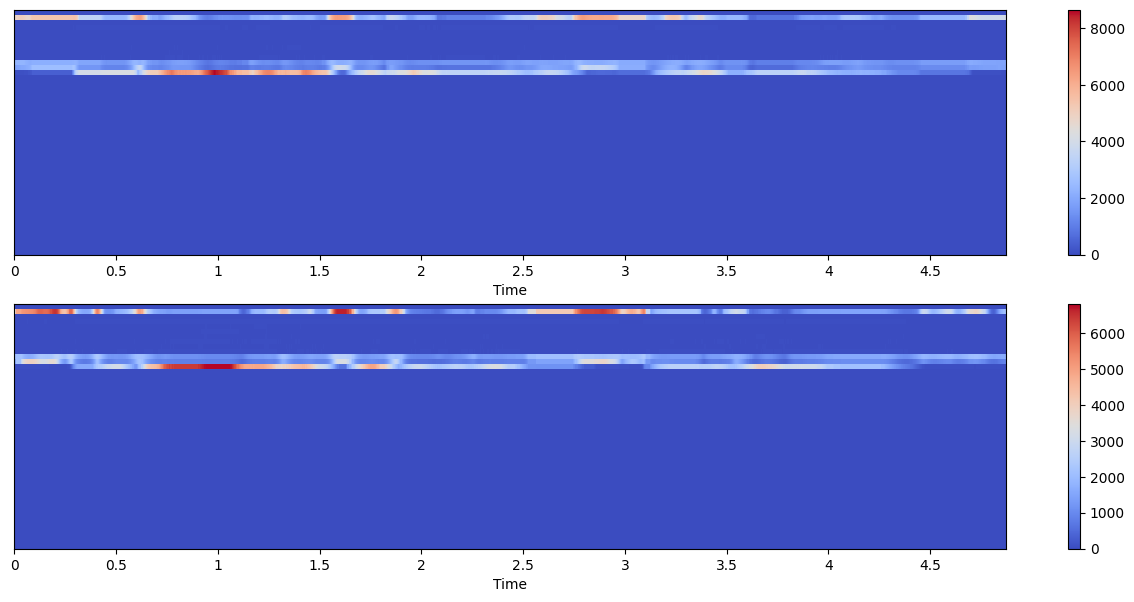

In [216]:
static_dim = X_aligned.shape[-1]
use_delta = False
if use_delta:
    X_aligned = DeltaAppender(windows).transform(X_aligned)
    Y_aligned = DeltaAppender(windows).transform(Y_aligned)

plot_parallel(X_aligned[idx],Y_aligned[idx])

Joint feature matrix


In [217]:
XY = np.concatenate((X_aligned, Y_aligned), axis=-1).reshape(-1, X_aligned.shape[-1]*2)
print(XY.shape)
XY = remove_zeros_frames(XY)    # remove padded zeros
print(XY.shape)

(123750, 98)
(70602, 98)


GMM Model

In [218]:
gmm = BayesianGaussianMixture(
    n_components=64, covariance_type="full", max_iter=100, verbose=1,random_state=10)

%time gmm.fit(XY)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
Initialization converged: False


c:\Users\YASH\miniconda3\envs\DOMINATOR\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


CPU times: total: 1h 42min 42s
Wall time: 19min 34s


BayesianGaussianMixture(n_components=64, random_state=10, verbose=1)

Visualisation of GMM parameters

In [219]:
# len(gmm.means_), len(gmm.covariances_)
gmm.means_.shape, gmm.covariances_.shape

((64, 98), (64, 98, 98))

Mean

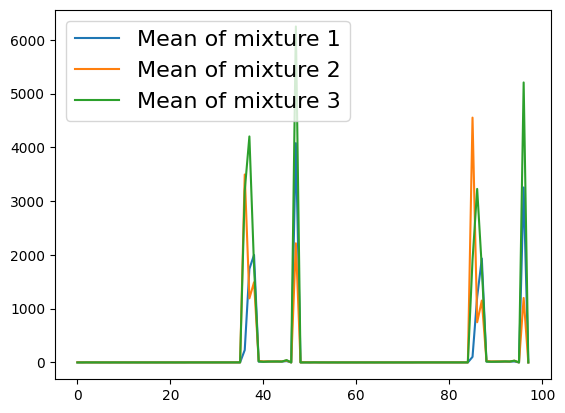

In [220]:
for k in range(3):
    plt.plot(gmm.means_[k], linewidth=1.5, label="Mean of mixture {}".format(k+1))
plt.legend(prop={"size": 16})

Covariance

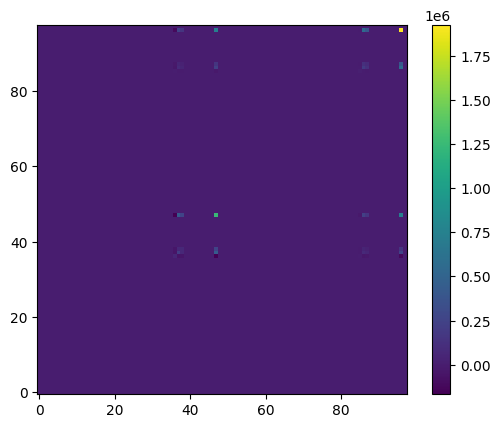

In [221]:
plt.imshow(gmm.covariances_[0], origin="lower")
plt.colorbar()

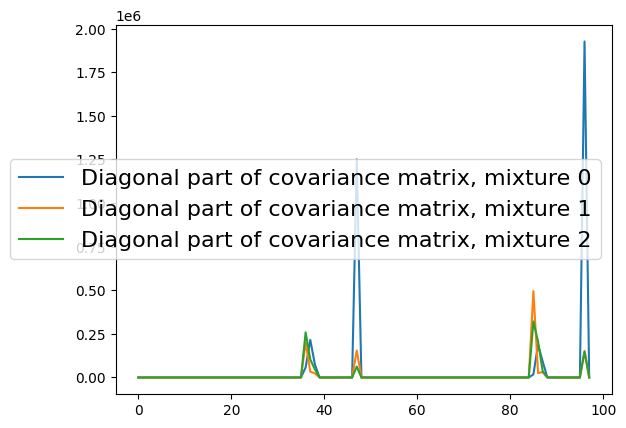

In [222]:
for k in range(3):
    plt.plot(np.diag(gmm.covariances_[k]), linewidth=1.5,
         label="Diagonal part of covariance matrix, mixture {}".format(k))
plt.legend(prop={"size": 16})

Testing

In [223]:
def test_one_utt(src_path, tgt_path, disable_mlpg=False, diffvc=True):
    # GMM-based parameter generation is provided by the library in `baseline` module
    if disable_mlpg:
        # Force disable MLPG
        paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=diffvc)
    else:
        paramgen = MLPG(gmm, windows=windows, diff=diffvc)

    fs, x = wavfile.read(src_path)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)

    mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)

    # add additional features
    features = extract_additional_features(x, fs)
    # discard first frame for consistency
    if len(mc) > len(features):
        mc = mc[1:,:]
    elif len(features) > len(mc):
        features = features[1:,:]
    mc = np.concatenate([mc, features], axis=1)

    # print("MCC:", mc.shape)
    c0, mc = mc[:, 0], mc[:, 1:]
    # print(">>>", c0.shape, mc.shape)

    if use_delta:
        mc = DeltaAppender(windows=windows).transform(
            mc[None, :, :]).reshape(-1, static_dim * len(windows))
    
    # print("Before Conversion MCC:", mc.shape)
    mc = paramgen.transform(mc)
    # print("Converted MCC:", mc.shape)

    if disable_mlpg and mc.shape[-1] != static_dim:
        # print("check disable mlpg")
        mc = mc[:,:static_dim]
    assert mc.shape[-1] == static_dim
    mc = np.hstack((c0[:, None], mc))

    if diffvc:
        mc[:, 0] = 0 # remove power coefficients
        # reduce feat dimension to MFCC order for speech synthesis
        mc = mc[:, :order+1]
        # print("Semi final MC", mc.shape, x.shape)

        engine = Synthesizer(MLSADF(order=order, alpha=alpha), hopsize=hop_length)
        b = pysptk.mc2b(mc.astype(np.float64), alpha=alpha)
        waveform = engine.synthesis(x, b)
    else:
        # print("Semi final MC", mc.shape)
        # mc = np.pad(mc, ((1,0), (0, 0)), 'constant')
        # print("Final MC", mc.shape)
        # mc = mc[:, :order+1]
        
        spectrogram = pysptk.mc2sp(
            mc.astype(np.float64), alpha=alpha, fftlen=fftlen)
        waveform = pyworld.synthesize(
            f0, spectrogram, aperiodicity, fs, frame_period)

    return waveform

In [224]:
save_dir = 'C:\\Users\\YASH\\Desktop\\SAP_Project\\save\\exp-12\\'
os.makedirs(save_dir, exist_ok=True)

for i, (src_path, tgt_path) in enumerate(zip(ksp_source.test_paths, jmk_source.test_paths)):
    print("{}-th sample".format(i+1))
    wo_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=True, diffvc=True)
    # w_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=False, diffvc=True)
    _, src = wavfile.read(src_path)
    _, tgt = wavfile.read(tgt_path)

    save_vc_path = save_dir + basename(src_path)

    print("Source:", basename(src_path))
    IPython.display.display(Audio(src, rate=fs))
    print("Target:", basename(tgt_path))
    IPython.display.display(Audio(tgt, rate=fs))
    print("w/o MLPG", basename(src_path))
    IPython.display.display(Audio(wo_MLPG, rate=fs))
    # print("w/ MLPG")
    # IPython.display.display(Audio(w_MLPG, rate=fs))

    # print("converted shape:", wo_MLPG.shape, wo_MLPG.dtype)

    # save converted voice 
    # librosa.output.write_wav(path=save_vc_path, y=wo_MLPG, sr=fs)
    # sf.write(save_vc_path, wo_MLPG, fs)
    wavfile.write(save_vc_path, fs, wo_MLPG.astype(np.int16))

1-th sample
Source: arctic_a0041.wav


Target: arctic_a0041.wav


w/o MLPG arctic_a0041.wav


2-th sample
Source: arctic_a0036.wav


Target: arctic_a0036.wav


w/o MLPG arctic_a0036.wav


3-th sample
Source: arctic_a0082.wav


Target: arctic_a0082.wav


w/o MLPG arctic_a0082.wav


4-th sample
Source: arctic_a0062.wav


Target: arctic_a0062.wav


w/o MLPG arctic_a0062.wav


5-th sample
Source: arctic_a0099.wav


Target: arctic_a0099.wav


w/o MLPG arctic_a0099.wav


6-th sample
Source: arctic_a0069.wav


Target: arctic_a0069.wav


w/o MLPG arctic_a0069.wav


7-th sample
Source: arctic_a0086.wav


Target: arctic_a0086.wav


w/o MLPG arctic_a0086.wav


8-th sample
Source: arctic_a0028.wav


Target: arctic_a0028.wav


w/o MLPG arctic_a0028.wav


9-th sample
Source: arctic_a0040.wav


Target: arctic_a0040.wav


w/o MLPG arctic_a0040.wav


10-th sample
Source: arctic_a0043.wav


Target: arctic_a0043.wav


w/o MLPG arctic_a0043.wav
